In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

In [2]:
data = pd.read_csv('titanic_dataset.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


`PassengerId` Unique ID of the passenger

`Survived` Survived (1) or died (0)

`Pclass` Passenger's class (1st, 2nd, or 3rd)

`Name`Passenger's name

`Sex` Passenger's sex

`Age` Passenger's age

`SibSp` Number of siblings/spouses aboard the Titanic

`Parch` Number of parents/children aboard the Titanic

`Ticket` Ticket number

`Fare` Fare paid for ticket

`Cabin` Cabin number

`Embarked` Where the passenger got on the ship (C - Cherbourg, S - Southampton, Q = Queenstown)

### Checking missing values and DF info in general

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We have some missing values on `Age`, `Cabin` and `Embarked`

### Checking data distribution

In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see 38% of people survived. Also, is interesting to see the max and min of certain features like Age and Fare.

I don't see any weird values or outliers that don't make sense or would affect the analysis.

...Just checking

In [6]:
data['Survived'].unique()

array([0, 1])

# Cleansing and Feature Engineering

The first thing to know is that we have (obviously) a classification problem.
The steps I think we need to take are the following:

* We need to deal with missing values from `Age`, `Cabin` and `Embarked`
* It seems to be a good idea to create a new feature combining `SibSp` and `Parch`: `fam_size`.
* Also, from `Name` we can extract a new feature: `Title`. Which would give us some information about the person.
* We also need to represent our features as numbers somehow, in particular `Title`, `Embarked`, `Cabin` and `Sex`.
    - `Embarked` does not seem to have any levels so one-hot encoding might work
    - `Sex` can be binary
    - `Cabin` might be tricky
    - `Title` can be a label encoding since it seems there are levels

## Missing values

In [7]:
total = data.isnull().sum().sort_values(ascending=False)

percent = total/len(data)*100

missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000


`Cabin` has 77% of missing values, I think it makes sense to get rid of it.

`Embarked` is a categorical feature and has 2 missing values so I think it makes sense to fill it with the mode

In [8]:
data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [9]:
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [10]:
data['Embarked'].mode().iloc[0]

'S'

In [11]:
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode().iloc[0])
data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

`Age` seems like a good feature for predicting survival, so I think we can do the following...

It is a good idea to check if it make sense to bucket the values.

Then, if it does, we can see the relationship between `Age` and the features `SibSp`, `Parch`and `Fare`.

Afterwards, for each missing value we check the `SibSp`, `Parch` and `Fare` values and by the similarity between its values and each bucket values we assign a bucket and then a median age of that bucket.

I chose `SibSp`, `Parch` and `Fare` because they seem to be more related to `Age`... but let's check that.

In [12]:
data.corr(method='pearson')['Age']

PassengerId    0.036847
Survived      -0.077221
Pclass        -0.369226
Age            1.000000
SibSp         -0.308247
Parch         -0.189119
Fare           0.096067
Name: Age, dtype: float64

So it seems `SibSp`, `Parch` and `Pclass` are the most correlated (negatively).

Bucketing

In [13]:
''' 
Buckets:
    0: 0-11, 1:12-17, 2:18-24, 3:25-34, 4:35-44, 5:45-54, 6:55-64, 7:65-80, 8:NaN
'''
bins = (12,18,25,35,45,55,65,80)
categories = np.digitize(data['Age'], bins)
data['age_group'] = categories

In [14]:
data.corr(method='pearson')['age_group']

PassengerId    0.000795
Survived      -0.115885
Pclass        -0.048274
Age            0.979672
SibSp         -0.132612
Parch         -0.218272
Fare          -0.028155
age_group      1.000000
Name: age_group, dtype: float64

In [15]:
''' 
The results should be a dict with bins as keys and 3 value vectors as values.
e.g.:
    {
    1:[2.5,4.3,1],
    2:[3.2, 2.1,2],
    .
    . etc..
    }
'''
desc = {}
for group in [0,1,2,3,4,5,6,7]:
    desc[group] = []
    desc[group].append(round(data[data['age_group']==group]['SibSp'].mean(),2))
    desc[group].append(round(data[data['age_group']==group]['Parch'].mean(), 2))
    desc[group].append(round(data[data['age_group']==group]['Pclass'].mean(), 2))
    desc[group] = np.array(desc[group])
desc

{0: array([1.88, 1.43, 2.63]),
 1: array([0.82, 0.49, 2.51]),
 2: array([0.33, 0.29, 2.46]),
 3: array([0.33, 0.19, 2.35]),
 4: array([0.37, 0.56, 2.  ]),
 5: array([0.41, 0.32, 1.67]),
 6: array([0.16, 0.32, 1.45]),
 7: array([0.1, 0.2, 1.8])}

In [16]:
from scipy.spatial import distance

'''
e.g.

arr = np.array([0,0,3])
s = distance_category(desc, arr)
res = 2
'''

def distance_category(desc, arr1):
    scores = {}
    for group in [0,1,2,3,4,5,6,7]:
        scores[distance.euclidean(desc[group], arr1)] = group
    return scores[min(scores.keys())]

In [17]:
data['isnull'] = data['Age'].isnull()
data['age_group'] = data.apply(lambda x: 
                               distance_category(desc, np.array([x['SibSp'], x['Parch'], x['Pclass']])) 
                               if x['isnull'] else x['age_group'], axis=1)

In [18]:
age_estim = {}
for group in [0,1,2,3,4,5,6,7]:
    age_estim[group] = int(data[data['age_group']==group]['Age'].mean())
age_estim        

{0: 4, 1: 15, 2: 21, 3: 29, 4: 38, 5: 48, 6: 59, 7: 68}

In [19]:
data['Age'] = data.apply(lambda x: age_estim[x['age_group']] if x['isnull'] else x['Age'], axis=1)

data = data.drop('isnull', axis=1)

In [20]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4
5,6,0,3,"Moran, Mr. James",male,21.0,0,0,330877,8.4583,NaN,Q,2
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,5
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,1


Awesome, now we don't have any missing values and we have a new feature `age_group`

### Family size

I decided Family size might be a good indicator so we'll add it just by adding Siblings-Spouse plus Parents-Children

In [21]:
data['fam_size'] = data.apply(lambda x: x['SibSp']+x['Parch'], axis=1)

### Title Extraction

In [22]:
import re

# Some titles I watched on a quick search
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major',
            'Dr', 'Ms', 'Capt','Don', 'other']
patterns = {
    re.compile(r'Mrs', re.IGNORECASE): 'Mrs',
    re.compile(r'Mr', re.IGNORECASE): 'Mr',
    re.compile(r'Master', re.IGNORECASE): 'Master',
    re.compile(r'Miss', re.IGNORECASE): 'Miss',
    re.compile(r'Major', re.IGNORECASE): 'Major',
    re.compile(r'Dr', re.IGNORECASE): 'Dr',
    re.compile(r'Ms', re.IGNORECASE): 'Ms',
    re.compile(r'Capt', re.IGNORECASE): 'Capt',
    re.compile(r'Don', re.IGNORECASE): 'Don',
}

def find_title(name):
    title = 'Other'
    for patt, val in patterns.items():
        if re.search(patt, name):
            title = val
    return title

In [23]:
data['title'] = data['Name'].map(lambda x: find_title(x))

In [24]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,age_group,fam_size,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,1,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4,1,Mr
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4,1,Mr
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,4,0,Mr


## Features to Numbers

We have to transform: `Title`, `Embarked`, `Cabin` and `Sex`.
I think it would be a good idea to do the following:
 
 * `Embarked`: One-hot encoding, 3 categories
 
 * `Sex`: Binary, 2 categories
 
 * `Cabin`: droped
 
 * `Title`: can be a label encoding (are there levels?)
 
 
 We can try this approach and see how it goes.
 
 Other options might be: 
 
 * `Sex`: One-hot encoding, 2 categories
 
 * `Title`: One-hot encoding
 

### Embarked Encoding

In [25]:
data = pd.concat([data, pd.get_dummies(data['Embarked'],prefix='embarked')],axis=1)
data = data.drop('Embarked', axis=1)

### Sex Encoding

In [26]:
data['sex_bi'] = data['Sex'].map(lambda x: 1 if x=='male' else 0)
data = data.drop('Sex', axis=1)

### Title encoding

In [27]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
data['title_label'] = label_encoder.fit_transform(data['title'])

data.groupby('title')['title_label'].unique()

title
Capt      [0]
Don       [1]
Dr        [2]
Major     [3]
Master    [4]
Miss      [5]
Mr        [6]
Ms        [7]
Other     [8]
Name: title_label, dtype: object

In [28]:
# drop original title
data = data.drop('title', axis=1)

# Feature Selection

I'll start by selecting empirically
* Some features I really don't see how they would help like `Cabin`, `PassengerId`, `Name` and `Ticket`

### Dropping some features

In [29]:
data = data.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,age_group,fam_size,embarked_C,embarked_Q,embarked_S,sex_bi,title_label
0,0,3,22.0,1,0,7.2500,2,1,0,0,1,1,6
1,1,1,38.0,1,0,71.2833,4,1,1,0,0,0,6
2,1,3,26.0,0,0,7.9250,3,0,0,0,1,0,5
3,1,1,35.0,1,0,53.1000,4,1,0,0,1,0,6
4,0,3,35.0,0,0,8.0500,4,0,0,0,1,1,6


### Correlations

In [30]:
data.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,age_group,fam_size,embarked_C,embarked_Q,embarked_S,sex_bi,title_label
Survived,1.000000,-0.338481,-0.021478,-0.035322,0.081629,0.257307,-0.022696,0.016639,0.168240,0.003650,-0.149683,-0.543351,-0.193407
Pclass,-0.338481,1.000000,-0.478147,0.083081,0.018443,-0.549500,-0.475189,0.065997,-0.243292,0.221009,0.074053,0.131900,0.062526
Age,-0.021478,-0.478147,1.000000,-0.321186,-0.201290,0.121118,0.984818,-0.320081,0.056885,-0.120416,0.025944,0.098307,0.176682
SibSp,-0.035322,0.083081,-0.321186,1.000000,0.414838,0.159651,-0.346890,0.890712,-0.059528,-0.026354,0.068734,-0.114631,-0.189470
Parch,0.081629,0.018443,-0.201290,0.414838,1.000000,0.216225,-0.222394,0.783111,-0.011069,-0.081228,0.060814,-0.245489,-0.145410
Fare,0.257307,-0.549500,0.121118,0.159651,0.216225,1.000000,0.123023,0.217138,0.269335,-0.117216,-0.162184,-0.182333,-0.129980
age_group,-0.022696,-0.475189,0.984818,-0.346890,-0.222394,0.123023,1.000000,-0.348192,0.053133,-0.128136,0.034090,0.107248,0.196661
fam_size,0.016639,0.065997,-0.320081,0.890712,0.783111,0.217138,-0.348192,1.000000,-0.046215,-0.058592,0.077359,-0.200988,-0.202141
embarked_C,0.168240,-0.243292,0.056885,-0.059528,-0.011069,0.269335,0.053133,-0.046215,1.000000,-0.148258,-0.782742,-0.082853,-0.047489
embarked_Q,0.003650,0.221009,-0.120416,-0.026354,-0.081228,-0.117216,-0.128136,-0.058592,-0.148258,1.000000,-0.499421,-0.074115,-0.066568


We have some obvious strong correlations between `SibSp`, `Parch` and `fam_size`, since we created that feature with them.

Also, between `Age` and `age_group`.

It's interesting to see that the only not obviuos strong correlation between the labels are between `embarked_S` and `embarked_C`.


The strongest correlation between the target and the features is with `sex_bi`, then `Pclass`.

## First attempts: Baseline models

I think we can try and build some models using these features and check the results

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score

I'll use **K-fold cross validation** to make our results more robust and take advantage of the STD, which we can use it as a "confidence" score for our precision estimation.

The only reason I use it is because we have a relatively small dataset and we can afford to do it, otherwise I would probably use regular cross validation.

Also, I am using a recall scoring, because the dataset is imbalanced (about 40/60), so accuracy is not very useful.

**Recall = TP/(TP+FN)**, which tells us the % of correctly classified positive values.


Another option could be Precision or F1-score (precision and recall combined).

The important point here is to avoid being affected by the imbalanced problem.

In [32]:
X_train = data.drop("Survived", axis=1)
Y_train = data["Survived"]

results = {'model':[], 'recall':[]}

### Random forest

As an example of the last point I compare the results from accuracy and recall, we can see there's a difference in the scores. Accuracy is a little too high due to imbalance.

In [33]:
rf = RandomForestClassifier(n_estimators=100, bootstrap = True)
scores = cross_validate(rf, X_train, Y_train, cv=10, scoring=['recall', 'accuracy'], return_train_score=True)

print("Train acc:", scores['train_accuracy'].mean())
print("Test acc:", scores['test_accuracy'].mean())

print("Train recall:", scores['train_recall'].mean())
print("Test recall:", scores['test_recall'].mean())

Train acc: 0.9850353781762946
Test acc: 0.8149026784700941
Train recall: 0.9717342104149921
Test recall: 0.7429411764705882


The rest of the tests will be using the recall score.

In [34]:
rf = RandomForestClassifier(n_estimators=100, bootstrap = True, n_jobs=-1)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring='recall')

results['model'].append('randomforest')
results['recall'].append(scores.mean())

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.71428571 0.68571429 0.61764706 0.88235294 0.82352941 0.76470588
 0.73529412 0.58823529 0.79411765 0.79411765]
Mean: 0.74
Standard Deviation: 0.08680001112941714


### Logistic Regression

In [35]:
logreg = LogisticRegression(solver='liblinear')
scores = cross_val_score(logreg, X_train, Y_train, cv=10, scoring = "recall")

results['model'].append('logitregression')
results['recall'].append(scores.mean())

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.65714286 0.71428571 0.58823529 0.82352941 0.76470588 0.64705882
 0.61764706 0.64705882 0.70588235 0.67647059]
Mean: 0.6842016806722689
Standard Deviation: 0.06667716415716068


### Naive Bayes

In [36]:
gaussian = GaussianNB()

scores = cross_val_score(gaussian, X_train, Y_train, cv=10, scoring = "recall")

results['model'].append('naivebayes')
results['recall'].append(scores.mean())


print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.68571429 0.71428571 0.67647059 0.82352941 0.79411765 0.73529412
 0.73529412 0.76470588 0.64705882 0.79411765]
Mean: 0.7370588235294118
Standard Deviation: 0.054483924119232294


### SVM

In [37]:
svm = SVC(kernel='rbf', degree=2, gamma='auto')

scores = cross_val_score(svm, X_train, Y_train, cv=10, scoring = "recall")

results['model'].append('svm')
results['recall'].append(scores.mean())

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.62857143 0.6        0.5        0.61764706 0.70588235 0.52941176
 0.64705882 0.64705882 0.61764706 0.67647059]
Mean: 0.6169747899159664
Standard Deviation: 0.05918472540211423


In [38]:
res = pd.DataFrame(results)
res = res.sort_values(by='recall', ascending=False)
res

,model,recall
0,randomforest,0.740000
2,naivebayes,0.737059
1,logitregression,0.684202
3,svm,0.616975


## Bias-Variance Balance

Now I want to know where I am in the bias-variance balance, even though we have good models if we want to improve accuracy we need to know first where we are so we know where we are going (how to improve).

For classification we can use a confusion matrix. I'll do it for the first 2 best models

In [39]:
# from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Random forest

**train vs test Error**

In [40]:
rf = RandomForestClassifier(n_estimators=100, bootstrap = True)
scores = cross_validate(rf, X_train, Y_train, cv=10, scoring='recall', return_train_score=True)

print("Train score:", scores['train_score'].mean())
print("Test score:", scores['test_score'].mean())

Train score: 0.9723825034899953
Test score: 0.7341176470588234


**Confusion matrix**

In [41]:
X = data.drop("Survived", axis=1)
Y = data["Survived"]

train, test, target_train, target_test = train_test_split(X, Y, test_size=0.2, shuffle=True ,random_state=6)

In [42]:
rf = RandomForestClassifier(n_estimators=100, bootstrap = True)
y_pred = rf.fit(train, target_train).predict(test)

In [43]:
arr = confusion_matrix(target_test, y_pred)
df = pd.DataFrame(arr, index = ['true_0', 'true_1'],
                  columns = ['pred_0', 'pred_1'])
df

,pred_0,pred_1
true_0,96,17
true_1,17,49


**Based on Train/Test Error**

For RF we can see we have some **overfitting**, that means we might have a variance problem.

To diminish the error we could regularized our model or select fewer features and see what happens.

* For the first one we could try searching for best hyperparameters (regulirizers).
* For the second we could find the best features and train with them.
* Another option could be to increase the numbers of trees used (n_estimators>100).

We can start by dropping `Age` and `fam_size`, since are the ones with the least correlation with the target.

### Naive Bayes

**test vs train Error**

In [44]:
gaussian = GaussianNB()
scores = cross_validate(gaussian, X_train, Y_train, cv=10, scoring=['recall', 'accuracy'], return_train_score=True)

print("Train acc:", scores['train_accuracy'].mean())
print("Test acc:", scores['test_accuracy'].mean())

print("Train recall:", scores['train_recall'].mean())
print("Test recall:", scores['test_recall'].mean())

Train acc: 0.7807702294071028
Test acc: 0.7734666893655657
Train recall: 0.739435889843056
Test recall: 0.7370588235294118


**confusion matrix**

In [45]:
y_pred = gaussian.fit(train, target_train).predict(test)

In [46]:
arr = confusion_matrix(target_test, y_pred)
df = pd.DataFrame(arr, index = ['true_0', 'true_1'],
                  columns = ['pred_0', 'pred_1'])
df

,pred_0,pred_1
true_0,94,19
true_1,16,50


**Based on Train/Test Error**

On the case of Naive Bayes since the error difference between the scores is not much we can say we don't have a lot of variance, it seems to be more of a **bias** problem or some **noise**.

This indicates that we may need to work more on our features to make them more significant or add new ones.

## Dropping obvious features for RF

I will try to improve the Random Forest model since I think the steps are more straight forward.

But it seems NB is less affected by imbalance... and kind of makes sense to take into account the "real" prior probability of survival.

In [47]:
drop1 = data.drop(['Age', 'fam_size'], axis=1)
drop1.head()

,Survived,Pclass,SibSp,Parch,Fare,age_group,embarked_C,embarked_Q,embarked_S,sex_bi,title_label
0,0,3,1,0,7.2500,2,0,0,1,1,6
1,1,1,1,0,71.2833,4,1,0,0,0,6
2,1,3,0,0,7.9250,3,0,0,1,0,5
3,1,1,1,0,53.1000,4,0,0,1,0,6
4,0,3,0,0,8.0500,4,0,0,1,1,6


In [48]:
X_train = drop1.drop("Survived", axis=1)
Y_train = drop1["Survived"]

In [49]:
rf = RandomForestClassifier(n_estimators=100, bootstrap = True)
scores = cross_validate(rf, X_train, Y_train, cv=10, scoring='recall', return_train_score=True)

print("Train score:", scores['train_score'].mean())
print("Test score:", scores['test_score'].mean())

Train score: 0.9272209061297009
Test score: 0.7193277310924369


In [50]:
drop2 = drop1.drop(['embarked_S'], axis=1)

drop2.head()

,Survived,Pclass,SibSp,Parch,Fare,age_group,embarked_C,embarked_Q,sex_bi,title_label
0,0,3,1,0,7.2500,2,0,0,1,6
1,1,1,1,0,71.2833,4,1,0,0,6
2,1,3,0,0,7.9250,3,0,0,0,5
3,1,1,1,0,53.1000,4,0,0,0,6
4,0,3,0,0,8.0500,4,0,0,1,6


In [51]:
X_train = drop2.drop("Survived", axis=1)
Y_train = drop2["Survived"]

I will also increase the # of samples for this one

In [52]:
rf = RandomForestClassifier(n_estimators=1000, bootstrap = True)
scores = cross_validate(rf, X_train, Y_train, cv=10, scoring='recall', return_train_score=True)

print("Train score:", scores['train_score'].mean())
print("Test score:", scores['test_score'].mean())

Train score: 0.92624899530437
Test score: 0.7223529411764705


I did closed the gap a little, but the difference is not much

## Random forest for feature importance

In [53]:
rf.fit(X_train, Y_train)
rf.feature_importances_

array([0.09175277, 0.06359935, 0.03891023, 0.30843381, 0.11570868,
       0.02325692, 0.01305114, 0.25721857, 0.08806853])

In [54]:
feat_imp = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feat_imp

,importance
Fare,0.308434
sex_bi,0.257219
age_group,0.115709
Pclass,0.091753
title_label,0.088069
SibSp,0.063599
Parch,0.038910
embarked_C,0.023257
embarked_Q,0.013051


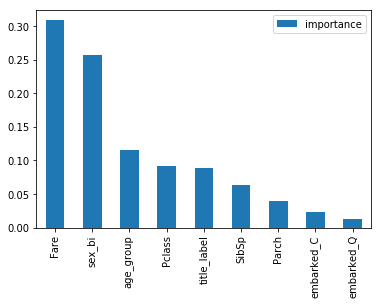

In [55]:
import matplotlib.pyplot as plt
feat_imp.plot.bar(y='importance')

## Dropping least important features

In [56]:
drop3 = drop2.drop(['embarked_C', 'embarked_Q'], axis=1)
drop3.head()

,Survived,Pclass,SibSp,Parch,Fare,age_group,sex_bi,title_label
0,0,3,1,0,7.2500,2,1,6
1,1,1,1,0,71.2833,4,0,6
2,1,3,0,0,7.9250,3,0,5
3,1,1,1,0,53.1000,4,0,6
4,0,3,0,0,8.0500,4,1,6


In [57]:
X_train = drop3.drop("Survived", axis=1)
Y_train = drop3["Survived"]

In [58]:
rf = RandomForestClassifier(n_estimators=1000, bootstrap = True)
scores = cross_validate(rf, X_train, Y_train, cv=10, scoring='recall', return_train_score=True)

print("Train score:", scores['train_score'].mean())
print("Test score:", scores['test_score'].mean())

Train score: 0.918125766741402
Test score: 0.7224369747899159


## Hyperparameters tunning

In [59]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(50, 1000).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10, 30],
    'criterion': ["gini", "entropy"],
    'bootstrap': [True],
    'oob_score':[True],
}

# Estimator for use in random search
estimator = RandomForestClassifier(n_jobs = -1, random_state = 42)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, scoring='recall', return_train_score=True,
                       cv =10, n_iter=10, verbose = 1, random_state=78)

# Fit 
rs.fit(X_train, Y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   33.3s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1,

In [60]:
rs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=16, max_features=0.7, max_leaf_nodes=39,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=922,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [61]:
print('Train score: ',rs.cv_results_['mean_train_score'].mean())
print('Test score: ',rs.cv_results_['mean_test_score'].mean())

Train score:  0.7683592791573248
Test score:  0.6982052080091296


In [62]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=16, max_features=0.7, max_leaf_nodes=39,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=922,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)
scores = cross_validate(rf, X_train, Y_train, cv=10, scoring=['recall', 'accuracy'], 
                        return_train_score=True, return_estimator=True)

print("Train acc:", scores['train_accuracy'].mean())
print("Test acc:", scores['test_accuracy'].mean())

print("Train recall:", scores['train_recall'].mean())
print("Test recall:", scores['test_recall'].mean())

Train acc: 0.9011094000671196
Test acc: 0.8316686528203382
Train recall: 0.8157927577308686
Test recall: 0.7135294117647059


In [63]:
from sklearn.externals import joblib

X = drop3.drop("Survived", axis=1)
Y = drop3["Survived"]

rf.fit(X, Y)

# save the model to disk
filename = 'rf1.sav'
joblib.dump(rf, filename)

/home/jorge/Envs/cppl/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['rf1.sav']

## NEXT STEPS

I have reduced the varience significantly but it seems we still have some overfitting and we could also benefit if we increase our model performance in general.

* Deal with imbalanced data: I would suggest re-sampling the data with a synthetic method (SMOTE). (For RF model)
* Try with Naive bayes model, improve performance.
* Improve features: by using other encoding or some clever engineering.
    - Combine features in a meaningful way (or randomly).
    - Carefully choose encoding method

# Summary

## Exploring
* Description
* Missing values
* Check distribution

## Cleaning
* Filling missing values from `Age`, `Cabin` and `Embarked`

## Feature Engineering
* New feature combining `SibSp` and `Parch`: `fam_size`.
* Extract a new feature: `Title`. Which would give us some information about the person.
* Encoding: `Title`, `Embarked` and `Sex`.

## Feature Selection
* Dropping `Cabin`, `PassengerId`, `Name` and `Ticket`
* Check correlations

## Modeling Baseline
* Random forest
* Logistic regression
* Naive bayes
* SVM
* Compare models

## Bias-Variance Balance
* Train vs test and confusion matrix: first 2 best models

## Attacking identified variance problem:
* Dropping features
* Check feature importance
* Drop more features
* Hyperparameter tuning: with random search
    - Added more trees
    - set number of leafs and max depth
* Re-train with best estimator and chosen features and check for the last time.
* Fit our estimator

## Save model
